In [26]:
from pathlib import Path
DATA_DIR = Path("./archive") 

In [27]:
main_jobs_fp = DATA_DIR/"postings.csv"  # main job postings file

In [28]:
paths = {
    "skills_map": DATA_DIR/"mappings/skills.csv",
    "industries_map": DATA_DIR/"mappings/industries.csv",
    "job_skills": DATA_DIR/"jobs/job_skills.csv",
    "job_industries": DATA_DIR/"jobs/job_industries.csv",
    "benefits": DATA_DIR/"jobs/benefits.csv",
    "salaries": DATA_DIR/"jobs/salaries.csv",
    "companies": DATA_DIR/"companies/companies.csv",
    "company_industries": DATA_DIR/"companies/company_industries.csv",
    "company_specialities": DATA_DIR/"companies/company_specialities.csv",
    "employee_counts": DATA_DIR/"companies/employee_counts.csv",
}


In [29]:
expected_cols = {
    "job_id","company_name","title","description","max_salary","pay_period","location",
    "company_id","views","med_salary","min_salary","formatted_work_type","applies",
    "original_listed_time","remote_allowed","job_posting_url","application_url",
    "application_type","expiry","closed_time","formatted_experience_level","skills_desc",
    "listed_time","posting_domain","sponsored","work_type","currency","compensation_type",
    "normalized_salary","zip_code","fips"
}


In [30]:
def safe_read_csv(fp, **kw):
    if not Path(fp).exists():
        raise FileNotFoundError(f"Missing file: {fp}")
    return pd.read_csv(fp, **kw)

# Load main jobs (let pandas infer; we’ll coerce critical fields later)
jobs = safe_read_csv(main_jobs_fp)

print("Loaded main jobs:", jobs.shape)
print("First 3 rows:\n", jobs.head(3), "\n")


Loaded main jobs: (123849, 31)
First 3 rows:
      job_id            company_name                              title  \
0    921716   Corcoran Sawyer Smith              Marketing Coordinator   
1   1829192                     NaN  Mental Health Therapist/Counselor   
2  10998357  The National Exemplar         Assitant Restaurant Manager   

                                         description  max_salary pay_period  \
0  Job descriptionA leading real estate firm in N...        20.0     HOURLY   
1  At Aspen Therapy and Wellness , we are committ...        50.0     HOURLY   
2  The National Exemplar is accepting application...     65000.0     YEARLY   

           location  company_id  views  med_salary  ...  \
0     Princeton, NJ   2774458.0   20.0         NaN  ...   
1  Fort Collins, CO         NaN    1.0         NaN  ...   
2    Cincinnati, OH  64896719.0    8.0         NaN  ...   

                                         skills_desc   listed_time  \
0  Requirements: \n\nWe are seeki

In [31]:
# 4) Schema validation
have = set(jobs.columns)
missing = sorted(list(expected_cols - have))
extra = sorted(list(have - expected_cols))
print("Missing columns:", missing)
print("Unexpected extra columns:", extra, "\n")


Missing columns: []
Unexpected extra columns: [] 



In [32]:
# 5) Type coercions (dates, numerics)
date_cols = ["original_listed_time","listed_time","expiry","closed_time"]
for c in date_cols:
    if c in jobs.columns:
        jobs[c] = pd.to_datetime(jobs[c], errors="coerce")

num_cols = ["views","applies","min_salary","med_salary","max_salary","normalized_salary","company_id"]
for c in num_cols:
    if c in jobs.columns:
        jobs[c] = pd.to_numeric(jobs[c], errors="coerce")


In [33]:
import numpy as np
def pct(x): 
    return round(100*x, 2)

n = len(jobs)
summary = {
    "rows": n,
    "unique_job_id": jobs["job_id"].nunique() if "job_id" in jobs else np.nan,
    "has_company_id_%": pct(jobs["company_id"].notna().mean()) if "company_id" in jobs else np.nan,
    "has_description_%": pct(jobs["description"].astype(str).str.len().gt(0).mean()) if "description" in jobs else np.nan,
    "has_skills_desc_%": pct(jobs.get("skills_desc", pd.Series([np.nan]*n)).astype(str).str.len().gt(0).mean()),
    "has_salary_any_%": pct(jobs[["min_salary","med_salary","max_salary","normalized_salary"]].notna().any(axis=1).mean()
                            if {"min_salary","med_salary","max_salary","normalized_salary"} <= set(jobs.columns) else np.nan),
    "has_views_%": pct(jobs["views"].notna().mean()) if "views" in jobs else np.nan,
    "has_applies_%": pct(jobs["applies"].notna().mean()) if "applies" in jobs else np.nan,
    "nonzero_views_%": pct((jobs.get("views", 0).fillna(0) > 0).mean()) if "views" in jobs else np.nan,
    "nonzero_applies_%": pct((jobs.get("applies", 0).fillna(0) > 0).mean()) if "applies" in jobs else np.nan,
}
print("=== MAIN TABLE SUMMARY ===")
for k,v in summary.items():
    print(f"{k:22s}: {v}")
print()


=== MAIN TABLE SUMMARY ===
rows                  : 123849
unique_job_id         : 123849
has_company_id_%      : 98.61
has_description_%     : 100.0
has_skills_desc_%     : 100.0
has_salary_any_%      : 29.13
has_views_%           : 98.64
has_applies_%         : 18.83
nonzero_views_%       : 98.64
nonzero_applies_%     : 18.83



In [34]:
loaded = {}
for name, fp in paths.items():
    try:
        df = safe_read_csv(fp)
        loaded[name] = df
        print(f"Loaded {name:20s}: {df.shape}")
    except Exception as e:
        print(f"!! Could not load {name}: {e}")

Loaded skills_map          : (35, 2)
Loaded industries_map      : (422, 2)
Loaded job_skills          : (213768, 2)
Loaded job_industries      : (164808, 2)
Loaded benefits            : (67943, 3)
Loaded salaries            : (40785, 8)
Loaded companies           : (24473, 10)
Loaded company_industries  : (24375, 2)
Loaded company_specialities: (169387, 2)
Loaded employee_counts     : (35787, 4)


In [35]:
job_skills = loaded.get("job_skills")
skills_map = loaded.get("skills_map")
job_inds = loaded.get("job_industries")
industries_map = loaded.get("industries_map")

In [36]:
skills_attached = np.nan
if job_skills is not None and "job_id" in jobs.columns:
    skills_attached = jobs["job_id"].isin(job_skills["job_id"]).mean()
inds_attached = np.nan
if job_inds is not None and "job_id" in jobs.columns:
    inds_attached = jobs["job_id"].isin(job_inds["job_id"]).mean()

print("\n=== LINK COVERAGE ===")
print("Jobs with ≥1 skill link %:", pct(skills_attached) if not pd.isna(skills_attached) else "n/a")
print("Jobs with ≥1 industry link %:", pct(inds_attached) if not pd.isna(inds_attached) else "n/a")


=== LINK COVERAGE ===
Jobs with ≥1 skill link %: 98.58
Jobs with ≥1 industry link %: 98.84


In [37]:
# 9) Quick distributions
for c in ["views","applies","normalized_salary","min_salary","med_salary","max_salary"]:
    if c in jobs.columns:
        desc = jobs[c].describe(percentiles=[.5,.75,.9,.95,.99])
        print(f"\n=== {c.upper()} describe ===\n{desc}")

# 10) Save a skinny sample (first 2k rows) for fast prototyping if needed
sample = jobs.sample(min(2000, len(jobs)), random_state=42)
sample_out = DATA_DIR/"_sample_jobs.csv"
sample.to_csv(sample_out, index=False)
print(f"\nWrote sample to: {sample_out}")


=== VIEWS describe ===
count    122160.000000
mean         14.618247
std          85.903598
min           1.000000
50%           4.000000
75%           8.000000
90%          23.000000
95%          48.000000
99%         177.000000
max        9975.000000
Name: views, dtype: float64

=== APPLIES describe ===
count    23320.000000
mean        10.591981
std         29.047395
min          1.000000
50%          3.000000
75%          8.000000
90%         24.000000
95%         45.000000
99%        133.810000
max        967.000000
Name: applies, dtype: float64

=== NORMALIZED_SALARY describe ===
count    3.607300e+04
mean     2.053270e+05
std      5.097627e+06
min      0.000000e+00
50%      8.150000e+04
75%      1.250000e+05
90%      1.680000e+05
95%      2.000000e+05
99%      3.008080e+05
max      5.356000e+08
Name: normalized_salary, dtype: float64

=== MIN_SALARY describe ===
count    2.979300e+04
mean     6.491085e+04
std      4.959738e+05
min      1.000000e+00
50%      6.000000e+04
75%    

In [38]:
# ========== Step 2: Expand Features ==========

# Expand skills and industries onto jobs
skills_map = loaded["skills_map"]
job_skills = loaded["job_skills"].merge(skills_map, on="skill_abr", how="left")

industries_map = loaded["industries_map"]
job_inds = loaded["job_industries"].merge(industries_map, on="industry_id", how="left")

# Aggregate skill and industry lists per job
skills_per_job = job_skills.groupby("job_id")["skill_name"].agg(lambda x: sorted(set(x.dropna()))).rename("skills_list")
inds_per_job = job_inds.groupby("job_id")["industry_name"].agg(lambda x: sorted(set(x.dropna()))).rename("industries_list")

jobs2 = jobs.set_index("job_id").join([skills_per_job, inds_per_job]).reset_index()

# Engagement metrics
jobs2["views"] = jobs2["views"].fillna(0)
jobs2["applies"] = jobs2["applies"].fillna(0)
jobs2["apply_rate"] = np.where(jobs2["views"] > 0, jobs2["applies"] / jobs2["views"], np.nan)

# Clean salaries: cap extreme outliers
for c in ["min_salary","med_salary","max_salary","normalized_salary"]:
    if c in jobs2.columns:
        jobs2.loc[jobs2[c] > 1e6, c] = np.nan  # drop unrealistic salaries

# Diagnostics: top skills and industries
top_skills = job_skills["skill_name"].value_counts().head(15)
top_inds = job_inds["industry_name"].value_counts().head(15)

print("=== TOP SKILLS (counts of jobs linked) ===")
print(top_skills, "\n")

print("=== TOP INDUSTRIES (counts of jobs linked) ===")
print(top_inds, "\n")

print("=== ENGAGEMENT SUMMARY ===")
print(jobs2[["views","applies","apply_rate"]].describe(percentiles=[.5,.75,.9,.95]))

=== TOP SKILLS (counts of jobs linked) ===
skill_name
Information Technology    26137
Sales                     22475
Management                20861
Manufacturing             18185
Health Care Provider      17369
Business Development      14290
Engineering               13009
Other                     12608
Finance                    8540
Marketing                  5525
Accounting/Auditing        5461
Administrative             4860
Customer Service           4292
Project Management         3997
Analyst                    3858
Name: count, dtype: int64 

=== TOP INDUSTRIES (counts of jobs linked) ===
industry_name
Hospitals and Health Care             18326
Retail                                11033
IT Services and IT Consulting         10396
Staffing and Recruiting                9005
Financial Services                     8535
Software Development                   5091
Manufacturing                          3689
Construction                           3445
Banking                  

In [19]:
%pip install networkx


Note: you may need to restart the kernel to use updated packages.


In [39]:
# ========== Step 3: Skill–Skill Network ==========

import networkx as nx

# Bipartite Job–Skill graph
B_js = nx.Graph()
B_js.add_nodes_from(jobs2["job_id"].tolist(), bipartite="job")
all_skills = set(s for lst in jobs2["skills_list"].dropna() for s in lst)
B_js.add_nodes_from(all_skills, bipartite="skill")

for _, row in jobs2.dropna(subset=["skills_list"]).iterrows():
    j = row["job_id"]
    for s in row["skills_list"]:
        B_js.add_edge(j, s)

# Project to Skill–Skill weighted network
skills_nodes = [n for n in B_js.nodes if n in all_skills]
S = nx.bipartite.weighted_projected_graph(B_js, skills_nodes)

print("Skill–Skill network:", S.number_of_nodes(), "nodes,", S.number_of_edges(), "edges")

# Centrality
deg_c = nx.degree_centrality(S)
# Adjust k to be no larger than number of nodes
k = min(500, S.number_of_nodes())
btw_c = nx.betweenness_centrality(S, k=k)  # sample for speed
try:
    eig_c = nx.eigenvector_centrality_numpy(S)
except:
    eig_c = {}

top_deg = pd.Series(deg_c).sort_values(ascending=False).head(15)
top_btw = pd.Series(btw_c).sort_values(ascending=False).head(15)
top_eig = pd.Series(eig_c).sort_values(ascending=False).head(15) if eig_c else None

print("\n=== Top Skills by Degree Centrality ===")
print(top_deg, "\n")
print("=== Top Skills by Betweenness Centrality ===")
print(top_btw, "\n")
if top_eig is not None:
    print("=== Top Skills by Eigenvector Centrality ===")
    print(top_eig, "\n")

# Community detection (Louvain if available)
try:
    comms = nx.community.louvain_communities(S, weight="weight", seed=42)
except Exception:
    import community as community_louvain
    parts = community_louvain.best_partition(S, weight="weight")
    from collections import defaultdict
    buckets = defaultdict(set)
    for node, cid in parts.items():
        buckets[cid].add(node)
    comms = list(buckets.values())

print("Detected", len(comms), "communities. Largest sizes:")
print(sorted([len(c) for c in comms], reverse=True)[:10])

Skill–Skill network: 35 nodes, 552 edges

=== Top Skills by Degree Centrality ===
Information Technology    1.000000
Analyst                   1.000000
Sales                     1.000000
Finance                   1.000000
Project Management        1.000000
Management                1.000000
Other                     1.000000
Customer Service          1.000000
Marketing                 1.000000
Administrative            1.000000
Engineering               1.000000
Strategy/Planning         1.000000
Research                  0.970588
Business Development      0.970588
General Business          0.970588
dtype: float64 

=== Top Skills by Betweenness Centrality ===
Information Technology    0.003099
Administrative            0.003099
Strategy/Planning         0.003099
Marketing                 0.003099
Engineering               0.003099
Other                     0.003099
Analyst                   0.003099
Customer Service          0.003099
Management                0.003099
Sales           

In [41]:
# ========== Step 4: Rebuild with association metrics ==========

from collections import Counter, defaultdict
import math
import pandas as pd
import numpy as np
import networkx as nx

# 1) Prepare per-job skill lists (already built as jobs2["skills_list"])
skill_lists = jobs2["skills_list"].dropna().tolist()

# Optionally drop generic buckets that muddy everything
GENERIC = {"Other"}  # add/remove as you see results
skill_lists = [[s for s in lst if s not in GENERIC] for lst in skill_lists]
skill_lists = [lst for lst in skill_lists if len(lst) >= 1]

# 2) Marginal counts and totals
skill_count = Counter()
for lst in skill_lists:
    skill_count.update(set(lst))  # set() to avoid duplicates within a job

N_jobs = len(skill_lists)

# 3) Co-occurrence counts
pair_count = Counter()
for lst in skill_lists:
    sl = sorted(set(lst))
    for i in range(len(sl)):
        for j in range(i+1, len(sl)):
            pair_count[(sl[i], sl[j])] += 1

# 4) Build edge table with association metrics
records = []
for (a,b), c_ab in pair_count.items():
    c_a = skill_count[a]
    c_b = skill_count[b]
    # Jaccard over jobs
    jacc = c_ab / (c_a + c_b - c_ab)
    # Lift: P(A,B) / (P(A)*P(B))
    p_a, p_b, p_ab = c_a / N_jobs, c_b / N_jobs, c_ab / N_jobs
    lift = p_ab / (p_a * p_b) if p_a>0 and p_b>0 else np.nan
    # PMI: log2( P(A,B) / (P(A)P(B)) )
    pmi = math.log2(lift) if lift and lift>0 else np.nan
    records.append((a,b,c_ab,c_a,c_b,jacc,lift,pmi))

edges = pd.DataFrame(records, columns=["u","v","cooc","cnt_u","cnt_v","jaccard","lift","pmi"]).sort_values("cooc", ascending=False)

# 5) Filter: keep edges that are frequent *and* strong association
COOC_MIN = 50           # raise/lower if graph too sparse/dense
PMI_MIN = 0.5           # >0 means more-than-random; 0.5 is mild
JACC_MIN = 0.02         # tiny Jaccard ok since skills are broad

edges_f = edges.query("cooc >= @COOC_MIN and pmi >= @PMI_MIN and jaccard >= @JACC_MIN").copy()

print("Edges total:", len(edges), " | After filters:", len(edges_f))

print("\n=== Top edges by co-occurrence ===")
print(edges.head(10)[["u","v","cooc","jaccard","pmi"]])

print("\n=== Top edges by PMI (min cooc filter applied) ===")
print(edges_f.sort_values("pmi", ascending=False).head(10)[["u","v","cooc","jaccard","pmi"]])

# 6) Build filtered graph and recompute centralities/communities
S2 = nx.Graph()
for _, r in edges_f.iterrows():
    S2.add_edge(r["u"], r["v"], weight=r["cooc"], pmi=r["pmi"], jaccard=r["jaccard"])

print("\nFiltered Skill–Skill graph:", S2.number_of_nodes(), "nodes,", S2.number_of_edges(), "edges")

deg_c2 = nx.degree_centrality(S2)
btw_c2 = nx.betweenness_centrality(S2, weight="weight")
try:
    eig_c2 = nx.eigenvector_centrality_numpy(S2, weight="weight")
except:
    eig_c2 = nx.eigenvector_centrality(S2, weight="weight", max_iter=5000)

top_deg2 = pd.Series(deg_c2, name="degree_c").sort_values(ascending=False).head(15)
top_btw2 = pd.Series(btw_c2, name="betweenness").sort_values(ascending=False).head(15)
top_eig2 = pd.Series(eig_c2, name="eigenvector").sort_values(ascending=False).head(15)

print("\n=== Filtered Top Skills by Degree Centrality ===")
print(top_deg2, "\n")
print("=== Filtered Top Skills by Betweenness Centrality ===")
print(top_btw2, "\n")
print("=== Filtered Top Skills by Eigenvector Centrality ===")
print(top_eig2, "\n")

# Communities
try:
    comms2 = nx.community.louvain_communities(S2, weight="weight", seed=42)
except Exception:
    import community as community_louvain
    parts = community_louvain.best_partition(S2, weight="weight", random_state=42)
    from collections import defaultdict
    buckets = defaultdict(set)
    for node, cid in parts.items():
        buckets[cid].add(node)
    comms2 = list(buckets.values())

print("Detected", len(comms2), "filtered communities. Largest sizes:",
      sorted([len(c) for c in comms2], reverse=True)[:10])

Edges total: 518  | After filters: 45

=== Top edges by co-occurrence ===
                         u                       v   cooc   jaccard       pmi
1               Management           Manufacturing  15938  0.718737  2.304205
13    Business Development                   Sales  12214  0.548131  2.278360
11             Engineering  Information Technology   8718  0.299917  1.625329
26     Accounting/Auditing                 Finance   3404  0.354362  3.250810
12                 Finance                   Sales   3391  0.131368  1.161413
0                Marketing                   Sales   2295  0.094452  1.167219
43                 Analyst                Research   2201  0.488894  4.478967
42                 Analyst  Information Technology   2147  0.079862  1.334492
31  Information Technology      Project Management   2039  0.075401  1.241048
44  Information Technology                Research   1919  0.073063  1.539085

=== Top edges by PMI (min cooc filter applied) ===
                

In [42]:
# ========== Step 5: Skill-level engagement (fixed) ==========

# explode skills into job-skill rows
jobs_sk = (
    jobs2.dropna(subset=["skills_list"])
         .explode("skills_list")[["job_id","skills_list","views","applies","apply_rate"]]
         .rename(columns={"skills_list":"skill"})
)

# consider jobs with >0 views
jobs_sk_v = jobs_sk[jobs_sk["views"] > 0].copy()

# aggregate at skill level
skill_eng = jobs_sk_v.groupby("skill").agg(
    jobs=("job_id","nunique"),
    total_views=("views","sum"),
    total_applies=("applies","sum"),
    mean_apply_rate=("apply_rate","mean")
).reset_index()

# weighted apply rate = total applies / total views
skill_eng["w_apply_rate"] = skill_eng["total_applies"] / skill_eng["total_views"]

# filter to skills with enough representation
MIN_JOBS = 200
skill_eng = (
    skill_eng[skill_eng["jobs"] >= MIN_JOBS]
    .sort_values("w_apply_rate", ascending=False)
)

print("=== Skill Engagement (min jobs =", MIN_JOBS, ") ===")
print(skill_eng.head(15))

=== Skill Engagement (min jobs = 200 ) ===
                     skill   jobs  total_views  total_applies  \
16  Information Technology  24971     512200.0       104484.0   
3                  Analyst   3705      95717.0        19243.0   
11             Engineering  12355     230926.0        45799.0   
15         Human Resources   2559      67175.0        10952.0   
6               Consulting   2099      47335.0         7532.0   
2              Advertising    634      15756.0         2395.0   
27       Quality Assurance   1724      27018.0         4072.0   
24      Project Management   3753      80840.0        12105.0   
32            Supply Chain   1153      18871.0         2818.0   
22      Product Management   1297      36189.0         5336.0   
20               Marketing   5303     136215.0        19878.0   
28                Research   2890      52546.0         7477.0   
34         Writing/Editing   1407      40082.0         5694.0   
8                   Design   2163      48471.0 

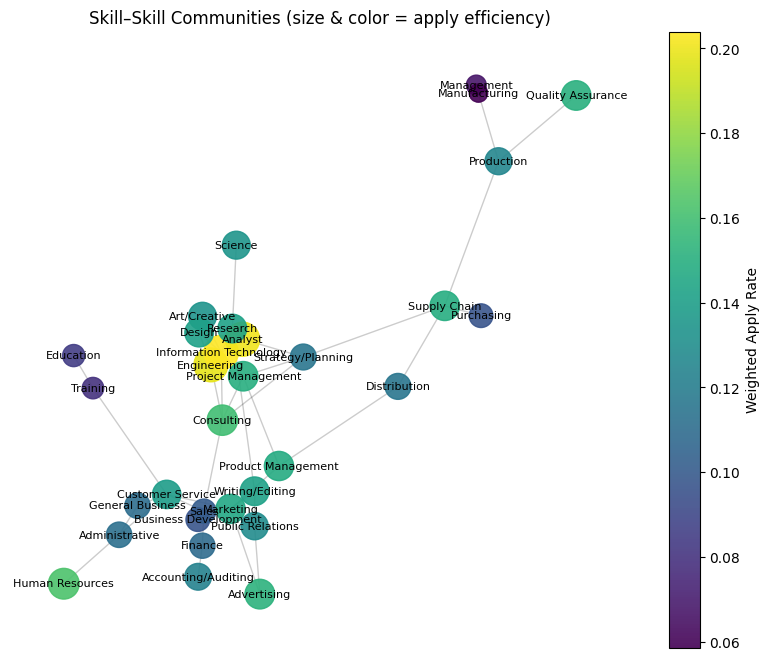

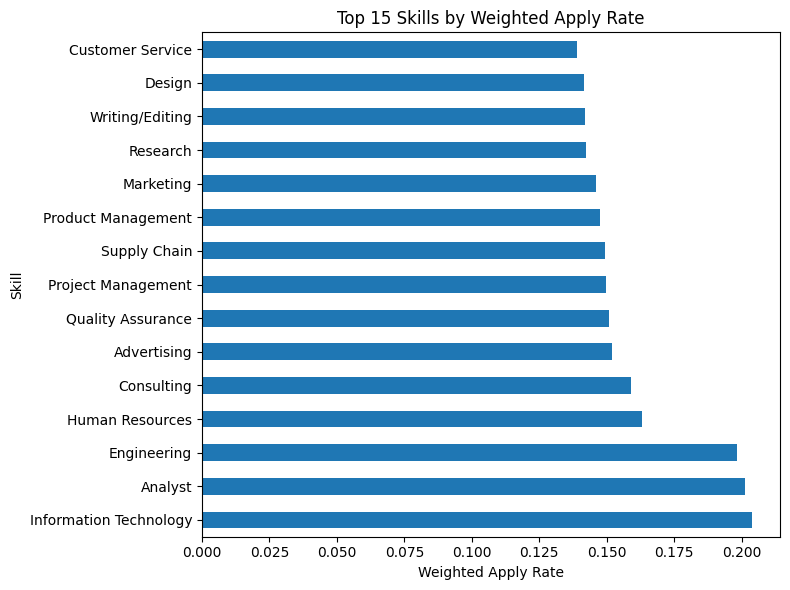

In [45]:
# ========== Step 6: Visuals ==========

import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
pos = nx.spring_layout(S2, k=0.25, iterations=50, seed=42)

# map w_apply_rate onto node sizes/colors
apply_map = dict(zip(skill_eng["skill"], skill_eng["w_apply_rate"]))
node_sizes = [3000 * apply_map.get(n, 0.05) for n in S2.nodes()]
node_colors = [apply_map.get(n, 0.05) for n in S2.nodes()]

# Draw nodes and capture the collection for colorbar
nodes = nx.draw_networkx_nodes(S2, pos,
                               node_size=node_sizes,
                               node_color=node_colors,
                               cmap=plt.cm.viridis,
                               alpha=0.9)
nx.draw_networkx_edges(S2, pos, alpha=0.2)
nx.draw_networkx_labels(S2, pos, font_size=8)
plt.title("Skill–Skill Communities (size & color = apply efficiency)")

# Use the nodes collection for the colorbar
plt.colorbar(nodes, label="Weighted Apply Rate")
plt.axis("off")
plt.show()

# 2) Top skills by weighted apply rate
topN = 15
skill_eng.head(topN).plot(x="skill", y="w_apply_rate", kind="barh",
                          figsize=(8,6), legend=False,
                          title=f"Top {topN} Skills by Weighted Apply Rate")
plt.xlabel("Weighted Apply Rate")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

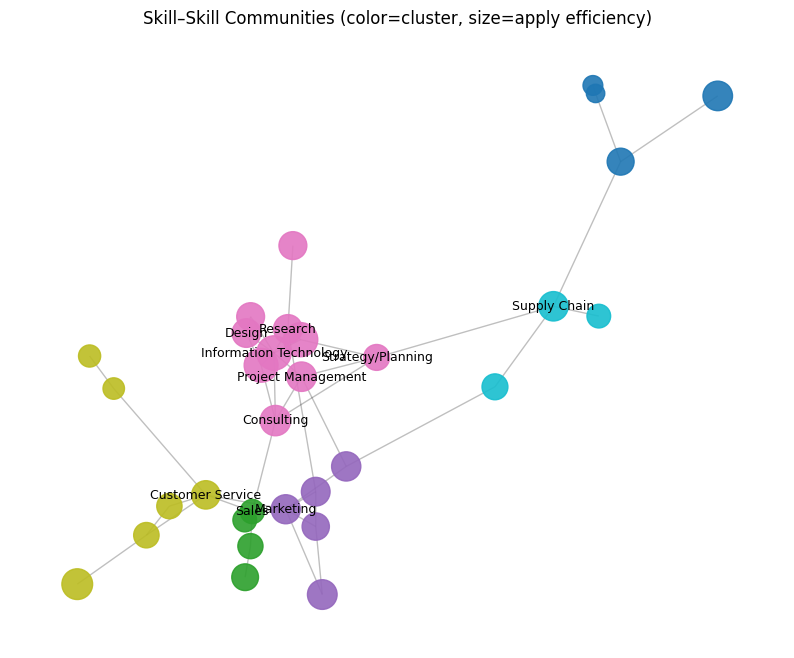

In [46]:
# ========== Optional: Community-colored plot ==========

# Assign community IDs
comm_id = {}
for cid, nodes in enumerate(comms2):
    for n in nodes:
        comm_id[n] = cid

plt.figure(figsize=(10,8))
pos = nx.spring_layout(S2, k=0.25, iterations=50, seed=42)

# size ~ efficiency, color ~ community
node_sizes = [3000 * apply_map.get(n, 0.05) for n in S2.nodes()]
node_colors = [comm_id.get(n, -1) for n in S2.nodes()]

nx.draw_networkx_nodes(S2, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.tab10,
                       alpha=0.9)
nx.draw_networkx_edges(S2, pos, alpha=0.25)

# label only top 10 by degree
labels = {n:n for n in top_deg2.head(10).index}
nx.draw_networkx_labels(S2, pos, labels=labels, font_size=9)

plt.title("Skill–Skill Communities (color=cluster, size=apply efficiency)")
plt.axis("off")
plt.show()

In [47]:
# ========== Step 7: Sentiment Analysis ==========

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def sent_score(text):
    if not isinstance(text, str) or not text.strip():
        return np.nan
    return sia.polarity_scores(text)["compound"]

# apply to description and skills_desc
jobs2["sent_description"] = jobs2["description"].apply(sent_score)
jobs2["sent_skills"] = jobs2["skills_desc"].apply(sent_score)

# combine: take max sentiment (so any strongly positive language counts)
jobs2["sentiment"] = jobs2[["sent_description","sent_skills"]].max(axis=1)

# bucket into categories
def sent_bucket(x):
    if pd.isna(x): return "neutral"
    if x > 0.1: return "positive"
    if x < -0.1: return "negative"
    return "neutral"

jobs2["sent_bucket"] = jobs2["sentiment"].apply(sent_bucket)

# --- Compare engagement by sentiment bucket ---
sent_group = jobs2.groupby("sent_bucket").agg(
    postings=("job_id","count"),
    mean_views=("views","mean"),
    mean_applies=("applies","mean"),
    mean_apply_rate=("apply_rate","mean")
).reset_index()

print("=== Engagement by Sentiment Bucket ===")
print(sent_group)

# --- Regression: apply_rate ~ sentiment + salary + views ---
dfm = jobs2.copy()
dfm = dfm[dfm["views"] > 0].copy()
dfm["log_views"] = np.log1p(dfm["views"])

import statsmodels.formula.api as smf

reg = smf.ols("apply_rate ~ sentiment + normalized_salary + log_views", data=dfm).fit()
print("\n=== OLS Regression ===")
print(reg.summary())

# Logistic: probability of any apply
dfm["any_apply"] = (dfm["applies"] > 0).astype(int)
log = smf.logit("any_apply ~ sentiment + normalized_salary + log_views", data=dfm).fit(disp=False)
print("\n=== Logistic Regression ===")
print(log.summary())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/omprakashgunja/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


=== Engagement by Sentiment Bucket ===
  sent_bucket  postings  mean_views  mean_applies  mean_apply_rate
0    negative       778    9.897172      1.289203         0.018580
1     neutral       602   16.661130      3.430233         0.058824
2    positive    122469   14.436592      1.991827         0.033656

=== OLS Regression ===
                            OLS Regression Results                            
Dep. Variable:             apply_rate   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     7444.
Date:                Sun, 21 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:41:42   Log-Likelihood:                 41939.
No. Observations:               35547   AIC:                        -8.387e+04
Df Residuals:                   35543   BIC:                        -8.384e+04
Df Model:                           3

Bipartite graph: 535 nodes, 867 edges
✓ Graph is properly bipartite


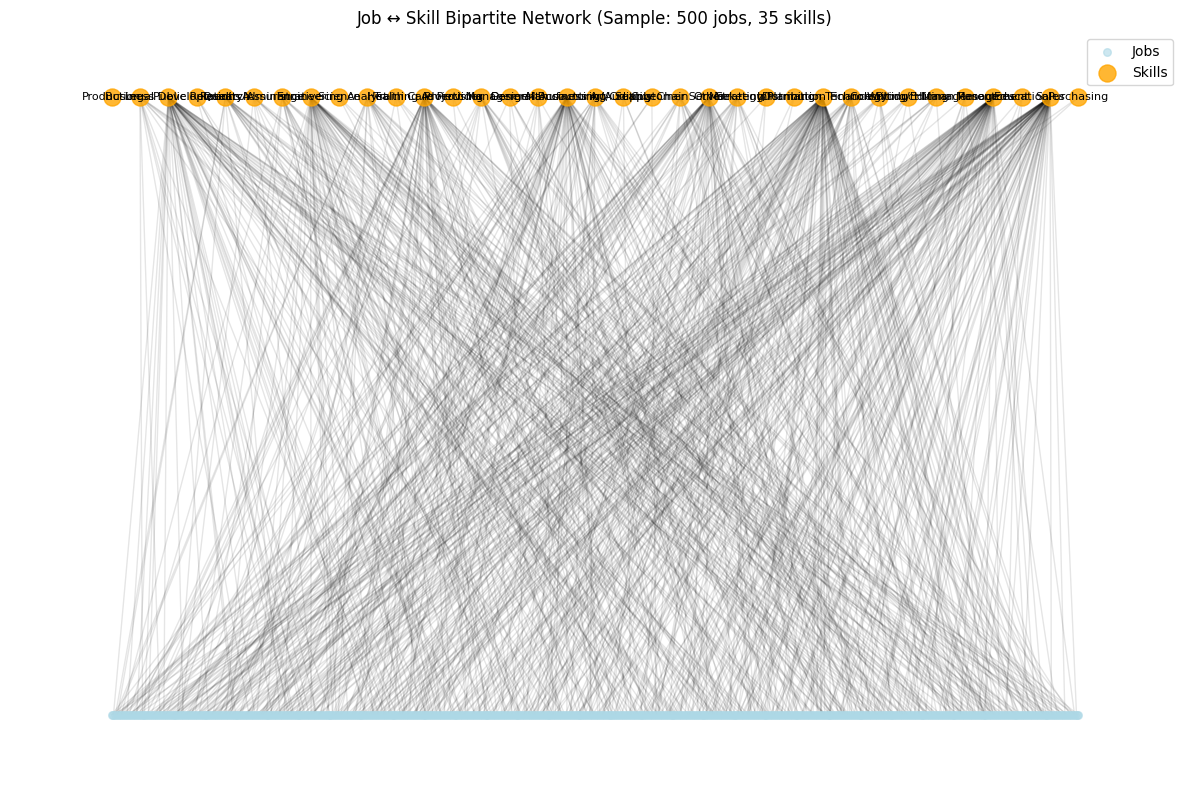

In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# ========== Bipartite Job–Skill Graph Visualization (Optimized) ==========

from networkx.algorithms import bipartite

# Limit to a manageable subset for visualization
MAX_JOBS = 500  # Reduce from potentially thousands
MAX_SKILLS = 50  # Show only top skills

# Get top skills by frequency
skill_freq = Counter()
for lst in jobs2["skills_list"].dropna():
    # Add type check to ensure we're working with lists
    if isinstance(lst, list):
        skill_freq.update(lst)

top_skills = [skill for skill, _ in skill_freq.most_common(MAX_SKILLS)]

# Sample a subset of jobs that have these top skills
jobs_with_top_skills = jobs2[
    jobs2["skills_list"].notna() & 
    jobs2["skills_list"].apply(lambda x: isinstance(x, list) and any(s in top_skills for s in x))
]
sample_jobs = jobs_with_top_skills.sample(min(MAX_JOBS, len(jobs_with_top_skills)), random_state=42)

# Build smaller bipartite graph
B = nx.Graph()
B.add_nodes_from(sample_jobs["job_id"].tolist(), bipartite=0)
B.add_nodes_from(top_skills, bipartite=1)

for _, row in sample_jobs.iterrows():
    # Add safety check for skills_list
    if isinstance(row["skills_list"], list):
        for s in row["skills_list"]:
            if s in top_skills:  # Only connect to top skills
                B.add_edge(row["job_id"], s)

print(f"Bipartite graph: {B.number_of_nodes()} nodes, {B.number_of_edges()} edges")

# Verify bipartite structure
if bipartite.is_bipartite(B):
    print("✓ Graph is properly bipartite")
else:
    print("⚠ Warning: Graph is not bipartite")

# Use bipartite layout for better visualization
jobs_nodes = [n for n in B.nodes() if n in sample_jobs["job_id"].values]
skills_nodes = [n for n in B.nodes() if n in top_skills]

pos = nx.bipartite_layout(B, jobs_nodes, align='horizontal')

plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(B, pos, nodelist=jobs_nodes, 
                       node_color="lightblue", node_size=30, alpha=0.6, label="Jobs")
nx.draw_networkx_nodes(B, pos, nodelist=skills_nodes, 
                       node_color="orange", node_size=150, alpha=0.8, label="Skills")
nx.draw_networkx_edges(B, pos, alpha=0.1)

# Label only the skills (not jobs - too cluttered)
skill_labels = {s: s for s in skills_nodes}
nx.draw_networkx_labels(B, pos, labels=skill_labels, font_size=8)

plt.legend()
plt.title(f"Job ↔ Skill Bipartite Network (Sample: {len(sample_jobs)} jobs, {len(top_skills)} skills)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [54]:
# Safer filter when building the bipartite graph
top_skills = job_skills["skill_name"].value_counts().head(15).index

jobs_sub = jobs2[
    jobs2["skills_list"].apply(
        lambda lst: isinstance(lst, list) and any(s in top_skills for s in lst)
    )
].copy()

# Build smaller bipartite
B_small = nx.Graph()
B_small.add_nodes_from(jobs_sub["job_id"], bipartite="job")
B_small.add_nodes_from(top_skills, bipartite="skill")

for _, row in jobs_sub.iterrows():
    if isinstance(row["skills_list"], list):
        for s in row["skills_list"]:
            if s in top_skills:
                B_small.add_edge(row["job_id"], s)

# Visualize
plt.figure(figsize=(10,8))
pos = nx.spring_layout(B_small, k=0.15, iterations=50, seed=42)
nx.draw(B_small, pos,
        with_labels=True,
        node_size=[50 if n in jobs_sub["job_id"].values else 800 for n in B_small.nodes()],
        node_color=["lightblue" if n in jobs_sub["job_id"].values else "orange" for n in B_small.nodes()],
        alpha=0.2)
plt.title("Job ↔ Top Skills Bipartite Network")
plt.show()

KeyboardInterrupt: 